In [27]:
import ruamel.yaml as yaml
import os
import sys
import pandas as pd
import numpy as np
import pandas_profiling
import altair as alt
alt.themes.enable('opaque')
%matplotlib inline


NO_CONFIG_ERR_MSG = """No config file found. Root directory is determined by presence of "config.yaml" file."""

original_wd = os.getcwd()

# Number of times to move back in directory
num_retries = 10
for x in range(0, num_retries):
    if os.path.exists("config.yaml"):
        break
    else:
        os.chdir('../')
        # If reached the max number of directory levels change to original wd and print error msg
        if x+1 == num_retries:
            os.chdir(original_wd)
            print(NO_CONFIG_ERR_MSG)


# Add directory to PATH
path = os.getcwd()

if path not in sys.path:
    sys.path.append(path)
    
from analysis_helpers import *

## Params

In [28]:
RESULTS_PATH = 'reports/output/'

In [29]:
from itertools import product
data_iterative_alg_combos = list(product(['cars', 'madelon'],  ['ANN', 'Boost', 'SVMLin', 'SVMRBF']))
data_alg_combos = list(product(['cars', 'madelon'],  ['ANN', 'Boost', 'DT', 'KNN', 'SVMLin', 'SVMRBF']))
data_alg_combos

[('cars', 'ANN'),
 ('cars', 'Boost'),
 ('cars', 'DT'),
 ('cars', 'KNN'),
 ('cars', 'SVMLin'),
 ('cars', 'SVMRBF'),
 ('madelon', 'ANN'),
 ('madelon', 'Boost'),
 ('madelon', 'DT'),
 ('madelon', 'KNN'),
 ('madelon', 'SVMLin'),
 ('madelon', 'SVMRBF')]

## Class to contain necessary Graphs for every algorithm

In [30]:
class AlgorithmResults(object):
    import altair as alt
    
    def __init__(self, results_fpath=None, algorithm=None, dataset=None, iterative=False):
        assert results_fpath, 'Must specify a directory with results outputs'
        assert algorithm, 'Must specify an algorithm'
        assert dataset, 'Must specify a dataset'
        self.results_fpath = results_fpath
        self.algorithm = algorithm
        self.dataset = dataset
        self.iterative = iterative
        self.df_dict = get_df_dict_from_algorithm_dataset(self.results_fpath,
                                                         algorithm=self.algorithm,
                                                         dataset=self.dataset)
        self.learning_curve_dfs = get_learning_curve_dfs(self.df_dict,
                                                        dataset=self.dataset,
                                                        algorithm=self.algorithm)
        self.timing_curve_dfs = get_timing_curve(self.df_dict,
                                                        dataset=self.dataset,
                                                        algorithm=self.algorithm)
        if self.iterative:
            self.overfitting_curve_dfs = get_overfitting_curve(self.df_dict,
                                                        dataset=self.dataset,
                                                        algorithm=self.algorithm)
        
    @property
    def plot_learning_curve(self, 
                            x=alt.X('Data_Points:Q'), 
                            y=alt.Y('CV_Mean:Q', scale=alt.Scale(domain=[0.0, 1.0])),
                           color=alt.Color('Split:N')):
        """ Plot the learning curve of the algorithm and dataset"""
        return alt.Chart(self.learning_curve_dfs).mark_line().encode(
        x=x,
        y=y,
        color=color
    )
    
    @property
    def plot_timing_curve(self, 
                            x=alt.X('Training_Fractional_Size:Q'), 
                            y=alt.Y('Time:Q'),
                           color=alt.Color('Function:N')):
        """ Plot the learning curve of the algorithm and dataset"""
        return alt.Chart(self.timing_curve_dfs).mark_line().encode(
            x=x,
            y=y,
            color=color,
        )
    
    @property
    def plot_overfitting_curve(self, 
                                x=alt.X('Max_Iterations/Estimators:Q'), 
                                y=alt.Y('Score:Q', scale=alt.Scale(domain=[0.0, 1.0])),
                               color=alt.Color('Split:N'),
                                  column=alt.Column('Hyperparameters:N')):
            """ Plot the learning curve of the algorithm and dataset"""
            # Only runs if learner is iterative
            if self.iterative:
                return alt.Chart(self.overfitting_curve_dfs).mark_line().encode(
                x=x,
                y=y,
                color=color,
                column=column)
            else:
                return None

## Learning Curves

In [31]:
data_alg_combos

[('cars', 'ANN'),
 ('cars', 'Boost'),
 ('cars', 'DT'),
 ('cars', 'KNN'),
 ('cars', 'SVMLin'),
 ('cars', 'SVMRBF'),
 ('madelon', 'ANN'),
 ('madelon', 'Boost'),
 ('madelon', 'DT'),
 ('madelon', 'KNN'),
 ('madelon', 'SVMLin'),
 ('madelon', 'SVMRBF')]

In [32]:
iterative_status_df = {
    'ANN':True,
    'Boost':True,
    'DT':False,
    'KNN':False,
    'SVMLin':True,
    'SVMRBF':True
}

## Overall Scores

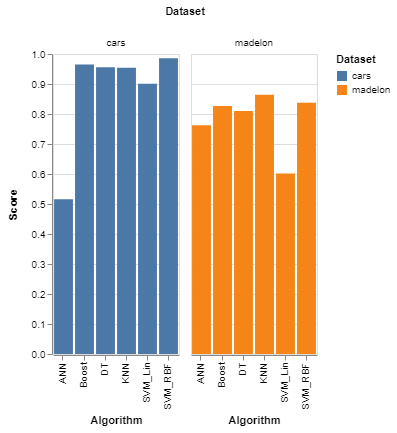

In [49]:
results = pd.read_csv('reports/output/test-results-reduced-cars.csv')
results['Best_Params'] = results.loc[:, 'Hyperparameters':].astype(str).sum(axis=1)
alt.Chart(results).mark_bar().encode(
    x='Algorithm:N',
    y=alt.Y('Score:Q', scale=alt.Scale(domain=[0.0, 1.0])),
    column='Dataset:N',
    color='Dataset:N'
)

## Best number of Iterators per Alg/Dataset

In [52]:
iterations = pd.read_csv('reports/output/best_number_of_iterations_by_data_algorithm_params_cars.csv')
             #.rename('Number_Of_Iterations':'Best_Number_Of_Iterations'))
iterations

,Dataset,Algorithm,Hyperparameters,Best_Number_of_Iterations/Estimators
0,cars,ANN,Best_Params,1024.0
1,cars,Boost,Best_Params,30.0
2,cars,SVMLin,Best_Params,1034.0
3,cars,SVMRBF,Best_Params,55.0
4,madelon,ANN,Best_Params,32.0
5,madelon,Boost,Best_Params,5.0
6,madelon,SVMLin,Best_Params,16.0
7,madelon,SVMRBF,Best_Params,128.0
8,cars,ANN,No_Regularization,1024.0
9,cars,Boost,No_Regularization,1.0


Notes:
Boosting with 1 iteration is a DT without regularization. Massive Overfitting

Scoring is based on Test Set Scores

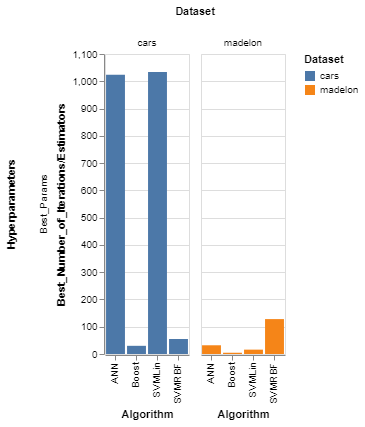

In [53]:
alt.Chart(iterations).mark_bar().encode(
    x='Algorithm:N',
    y=alt.Y('Best_Number_of_Iterations/Estimators:Q'),
    column='Dataset:N',
    row='Hyperparameters:N',
    color='Dataset:N'
).transform_filter(
    (alt.datum.Hyperparameters == 'Best_Params') 
)

Algorithm: ANN
Dataset: cars


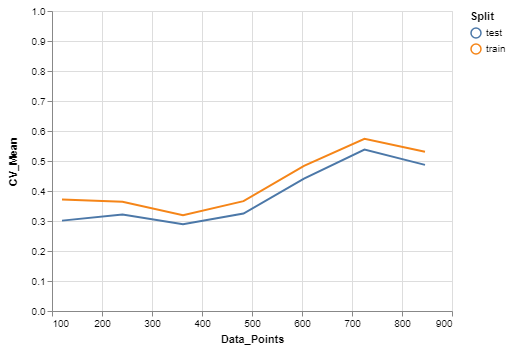

Algorithm: Boost
Dataset: cars


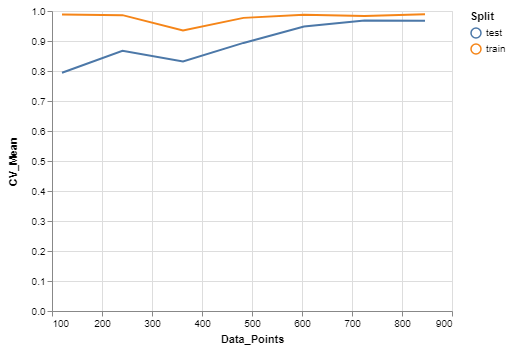

Algorithm: DT
Dataset: cars


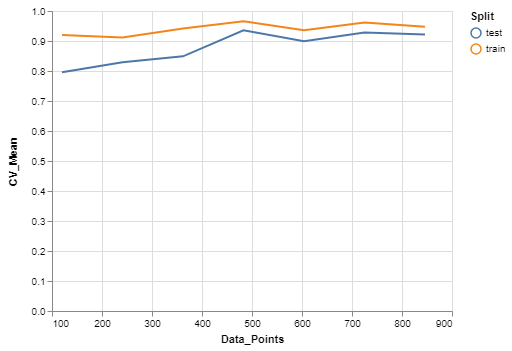

Algorithm: KNN
Dataset: cars


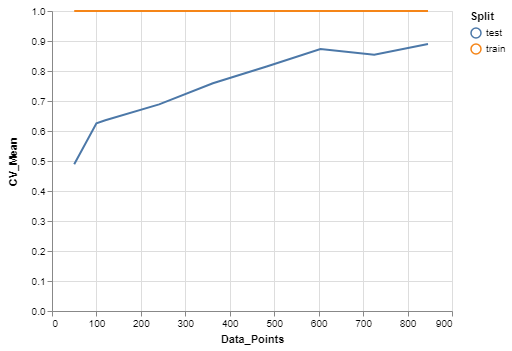

Algorithm: SVMLin
Dataset: cars


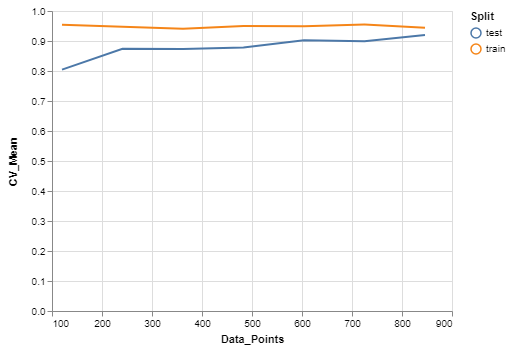

Algorithm: SVMRBF
Dataset: cars


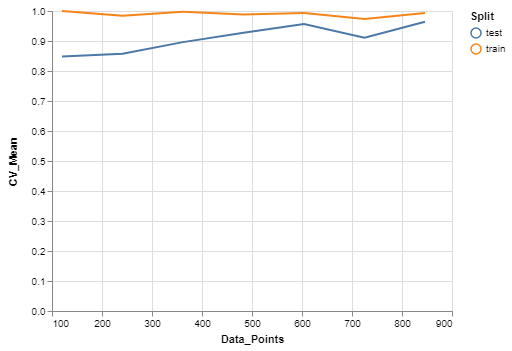

Algorithm: ANN
Dataset: madelon


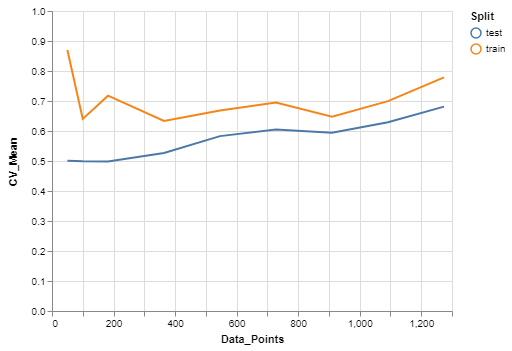

Algorithm: Boost
Dataset: madelon


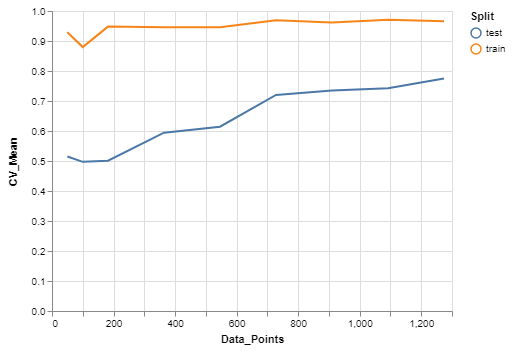

Algorithm: DT
Dataset: madelon


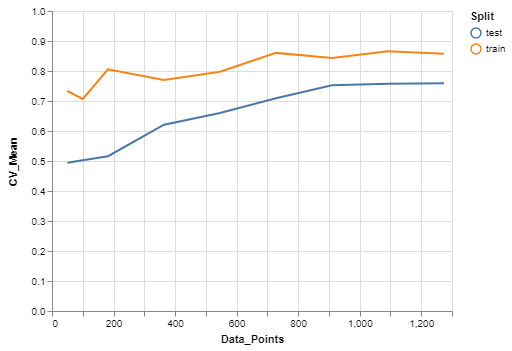

Algorithm: KNN
Dataset: madelon


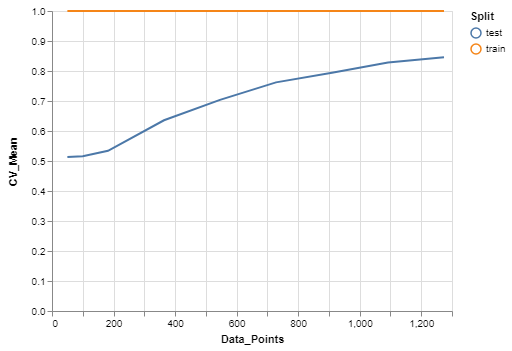

Algorithm: SVMLin
Dataset: madelon


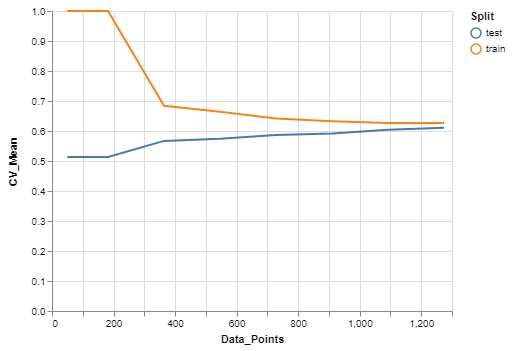

Algorithm: SVMRBF
Dataset: madelon


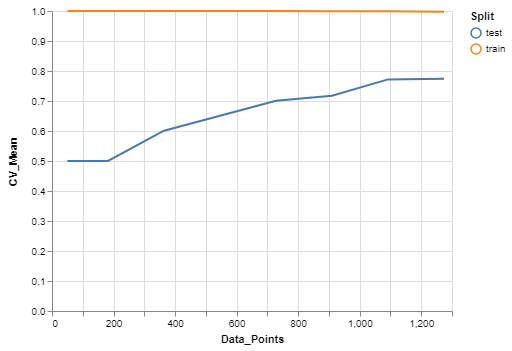

In [36]:
for dataset, algorithm in data_alg_combos:
    test_object = AlgorithmResults(results_fpath=RESULTS_PATH, 
                                   dataset=dataset,
                                   algorithm=algorithm,
                                  iterative=iterative_status_df[algorithm])
    
    print(f'Algorithm: {algorithm}')
    print(f'Dataset: {dataset}')    
    
    display(test_object.plot_learning_curve)

## Learning Curves side by side

In [37]:
data_iterative_alg_combos = list(product(['cars', 'madelon'],  ['ANN', 'Boost', 'SVMLin', 'SVMRBF']))
learners =  ['ANN', 'DT', 'Boost', 'KNN', 'SVMLin', 'SVMRBF']
sets = ['cars', 'madelon']

ANN


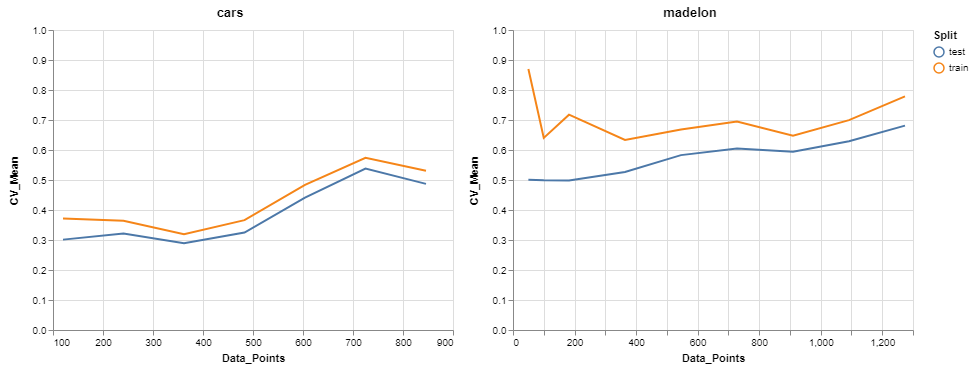

DT


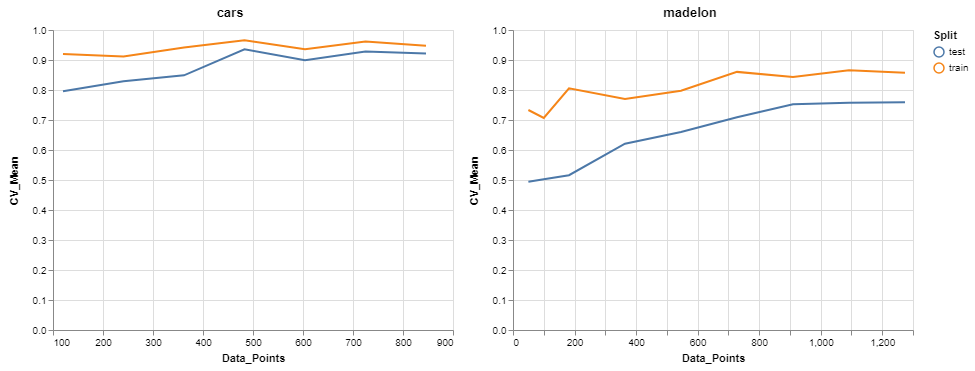

Boost


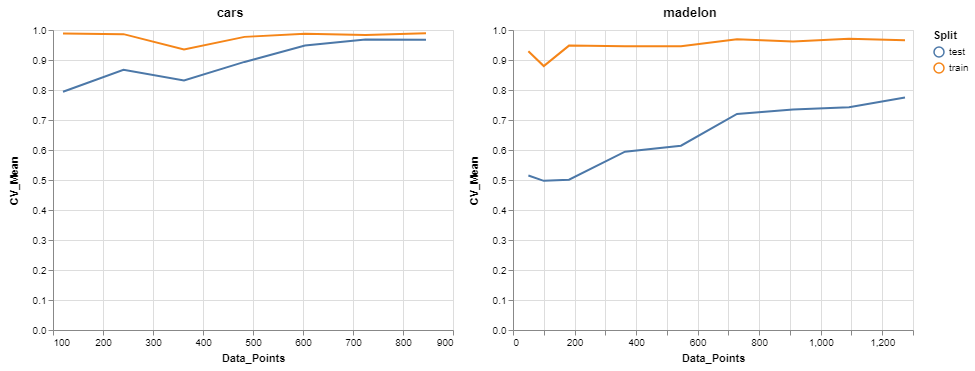

KNN


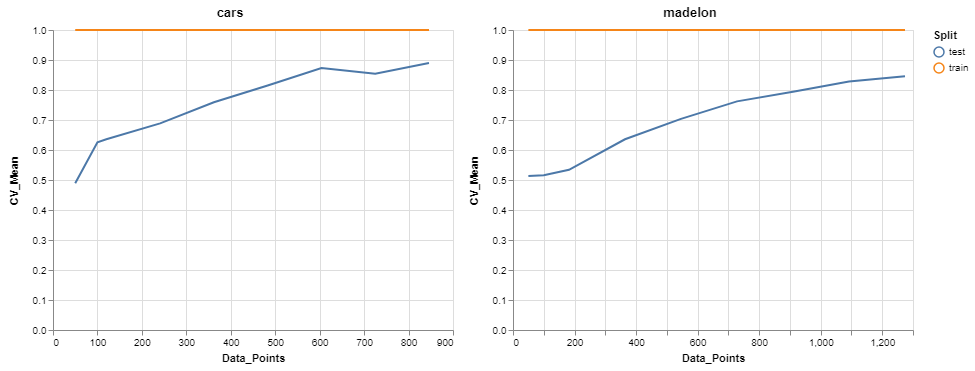

SVMLin


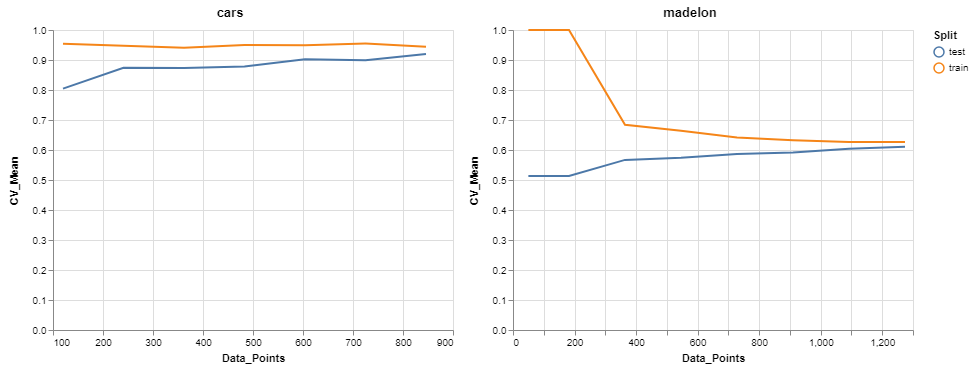

SVMRBF


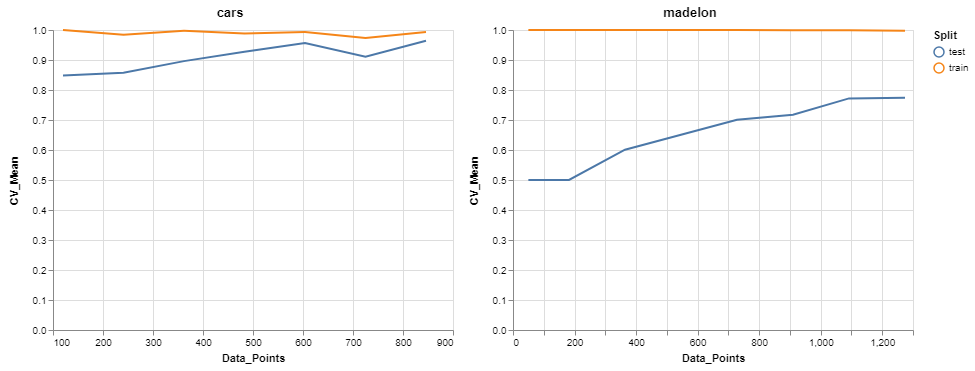

In [38]:
for algorithm in learners:
    learning_curve_plots = []
    for dataset in sets:
        analysis_plotter = AlgorithmResults(results_fpath=RESULTS_PATH, 
                               dataset=dataset,
                               algorithm=algorithm,
                              iterative=iterative_status_df[algorithm])
        learning_curve_plots.append(analysis_plotter.plot_learning_curve.properties(
    title=f'{dataset}'))
    one, two = learning_curve_plots
    print(algorithm)
    display(one | two)

## Timing Curves

Algorithm: ANN
Dataset: cars


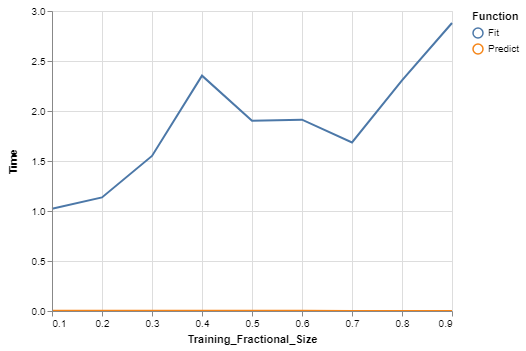

Algorithm: Boost
Dataset: cars


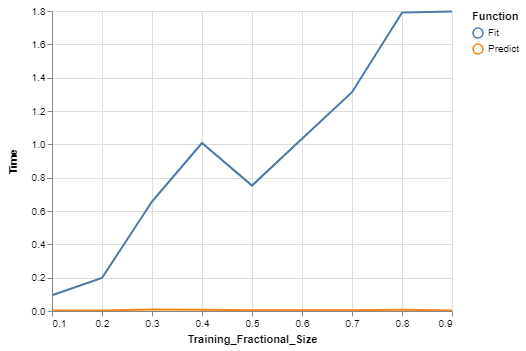

Algorithm: DT
Dataset: cars


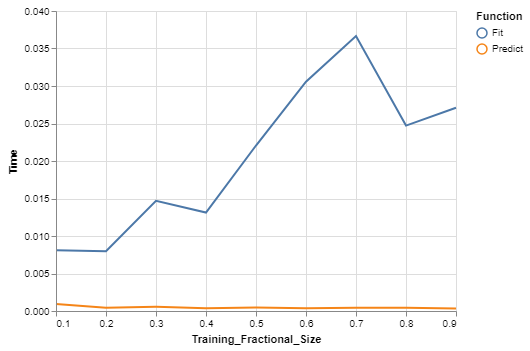

Algorithm: KNN
Dataset: cars


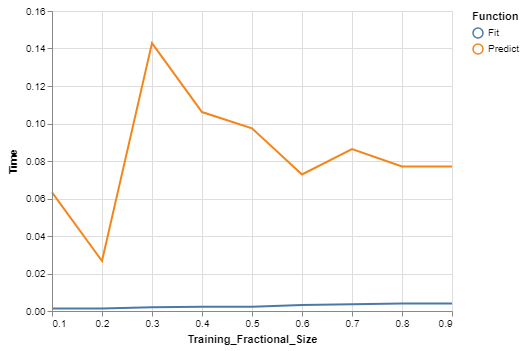

Algorithm: SVMLin
Dataset: cars


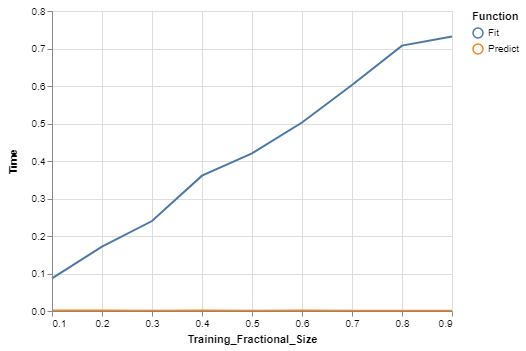

Algorithm: SVMRBF
Dataset: cars


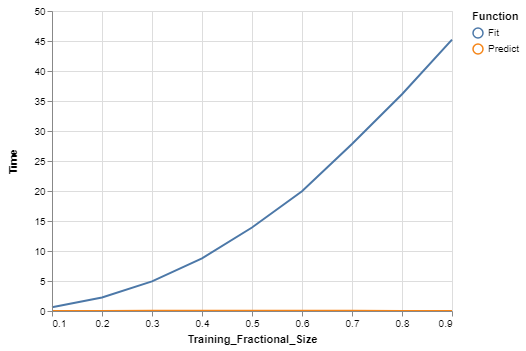

Algorithm: ANN
Dataset: madelon


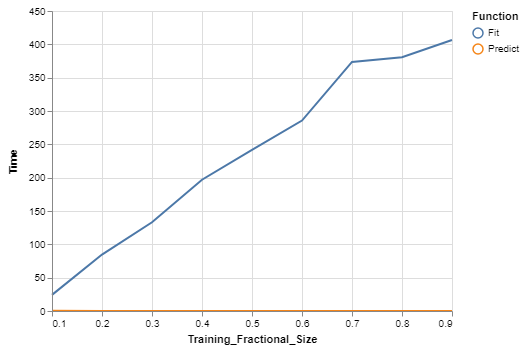

Algorithm: Boost
Dataset: madelon


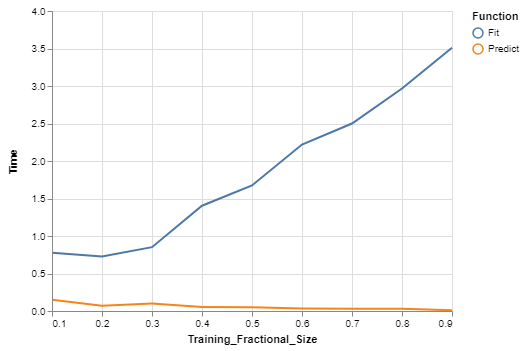

Algorithm: DT
Dataset: madelon


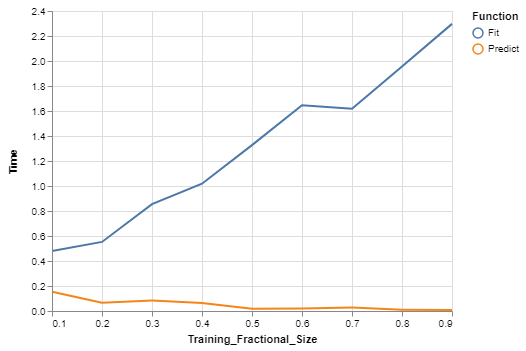

Algorithm: KNN
Dataset: madelon


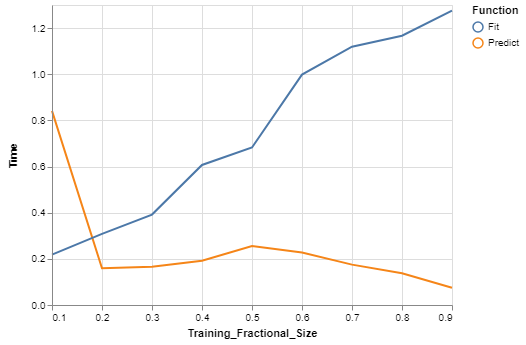

Algorithm: SVMLin
Dataset: madelon


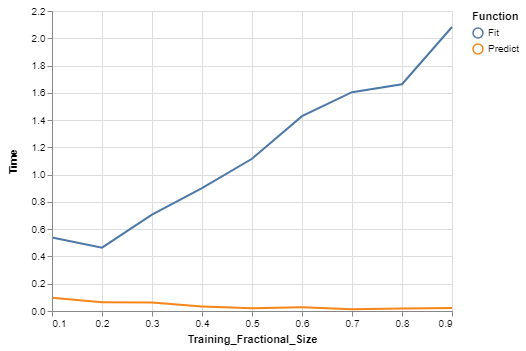

Algorithm: SVMRBF
Dataset: madelon


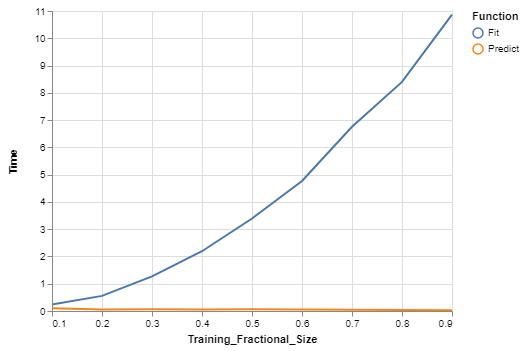

In [39]:
for dataset, algorithm in data_alg_combos:
    test_object = AlgorithmResults(results_fpath=RESULTS_PATH, 
                                   dataset=dataset,
                                   algorithm=algorithm,
                                   iterative=iterative_status_df[algorithm]
                                  )
    
    print(f'Algorithm: {algorithm}')
    print(f'Dataset: {dataset}')    
    display(test_object.plot_timing_curve)

## Side by Side

ANN


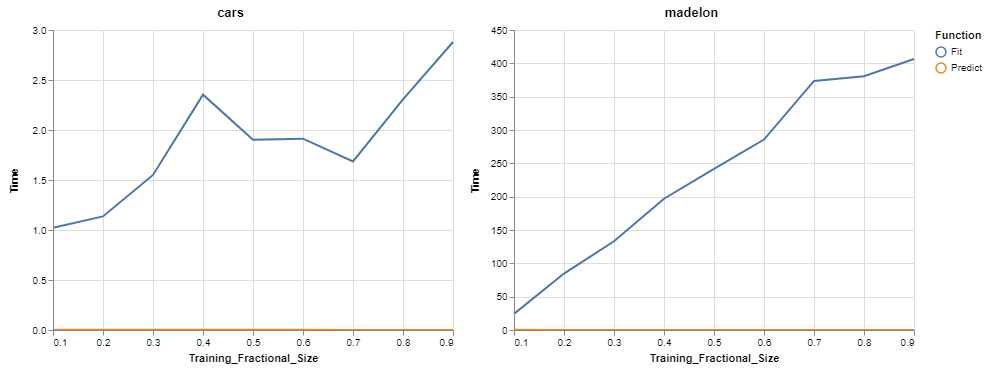

DT


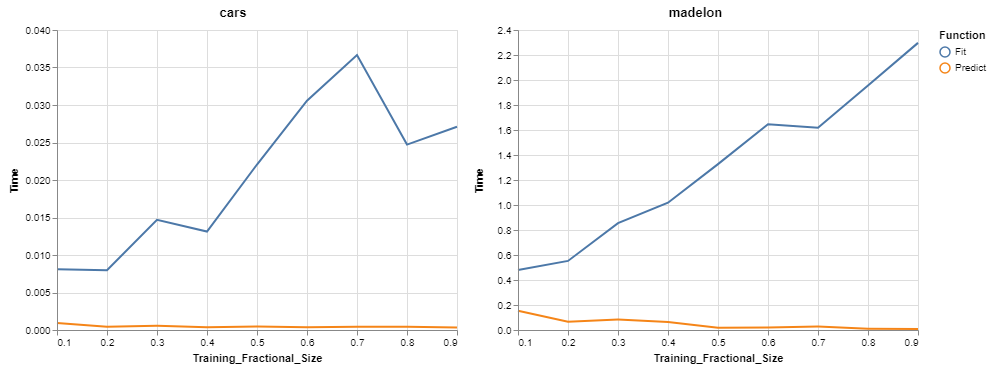

Boost


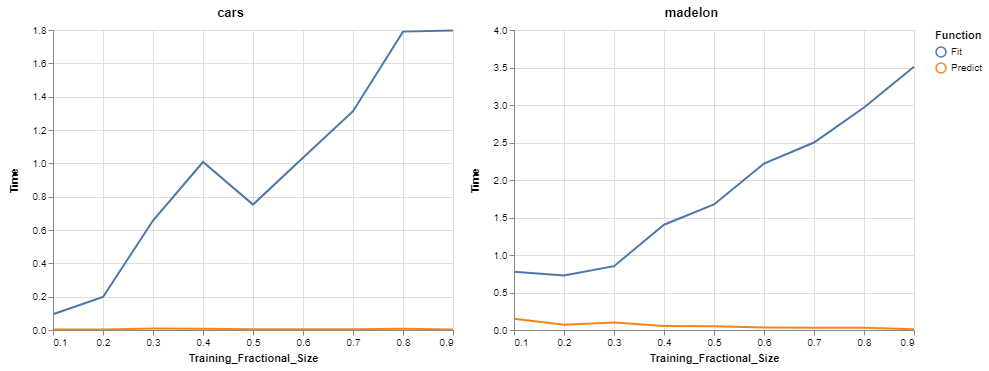

KNN


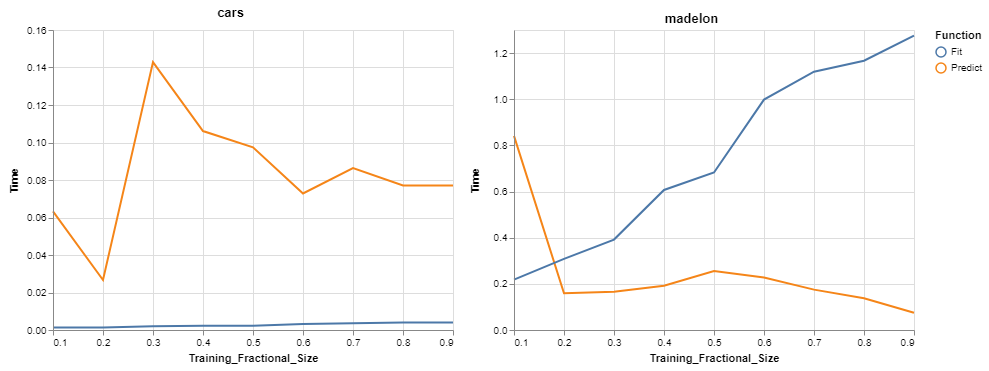

SVMLin


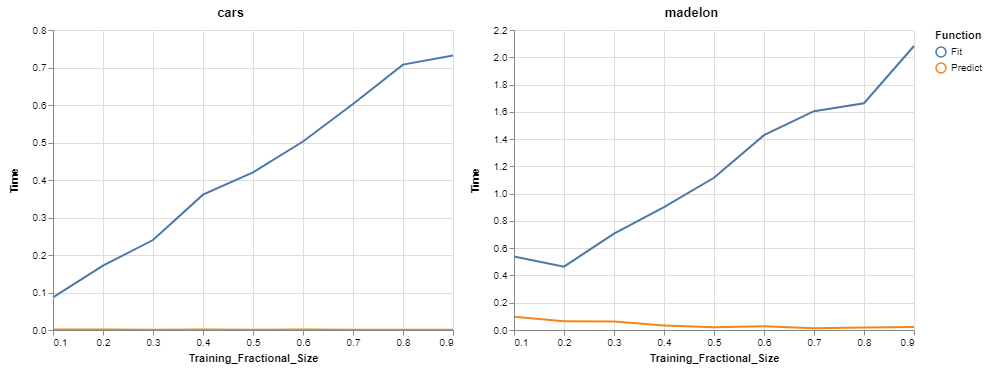

SVMRBF


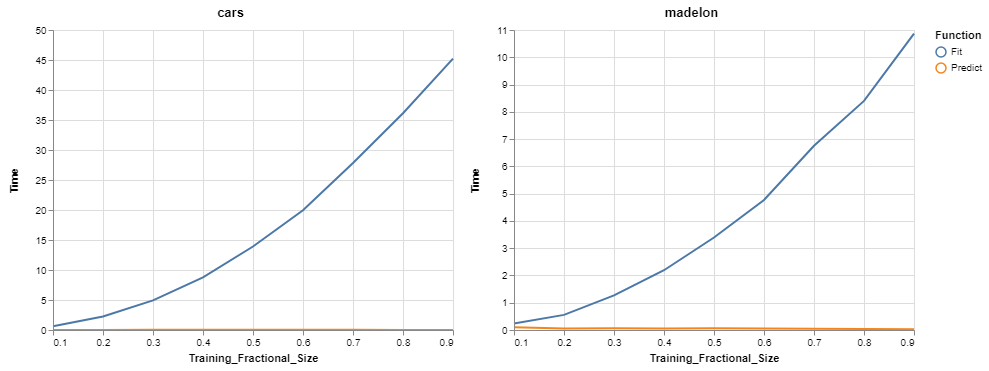

In [40]:
for algorithm in learners:
    timing_curves = []
    for dataset in sets:
        analysis_plotter = AlgorithmResults(results_fpath=RESULTS_PATH, 
                               dataset=dataset,
                               algorithm=algorithm,
                              iterative=iterative_status_df[algorithm])
        timing_curves.append(analysis_plotter.plot_timing_curve.properties(
    title=f'{dataset}'))
    one, two = timing_curves
    print(algorithm)
    display(one | two)

## Layered

In [67]:
timing_curves = []
for algorithm in learners:
    for dataset in sets:
        analysis_plotter = AlgorithmResults(results_fpath=RESULTS_PATH, 
                               dataset=dataset,
                               algorithm=algorithm,
                              iterative=iterative_status_df[algorithm])
        timing_curves.append(analysis_plotter.timing_curve_dfs)
timing_curves_all = pd.concat(timing_curves)        

In [68]:
timing_curves_all.head()

,Training_Fractional_Size,Function,Time,Algorithm,Dataset
0,0.9,Fit,2.880118,ANN,cars
1,0.8,Fit,2.306128,ANN,cars
2,0.7,Fit,1.685350,ANN,cars
3,0.6,Fit,1.913409,ANN,cars
4,0.5,Fit,1.902528,ANN,cars


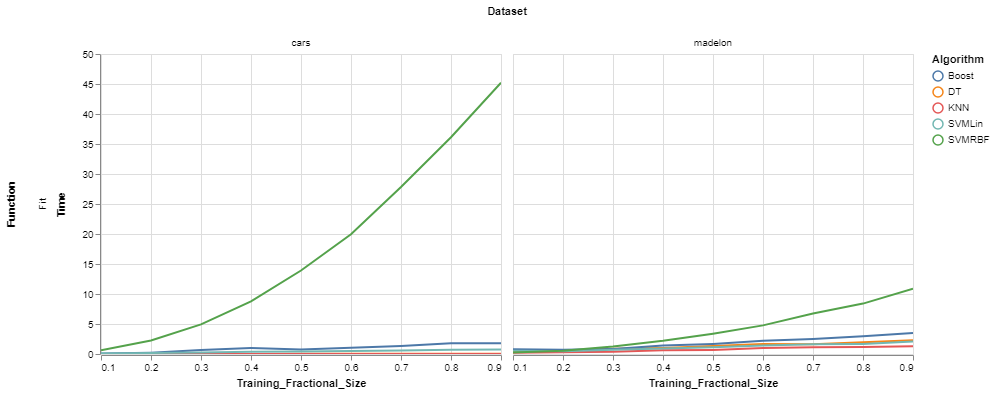

In [80]:
alt.Chart(timing_curves_all).mark_line().encode(
    alt.X('Training_Fractional_Size:Q'), 
    y=alt.Y('Time:Q'),
    color=alt.Color('Algorithm:N'),
    row='Function:N',
    column='Dataset:N',
).transform_filter(
    (alt.datum.Algorithm != 'ANN') 
    &
    (alt.datum.Function == 'Fit')
).interactive()

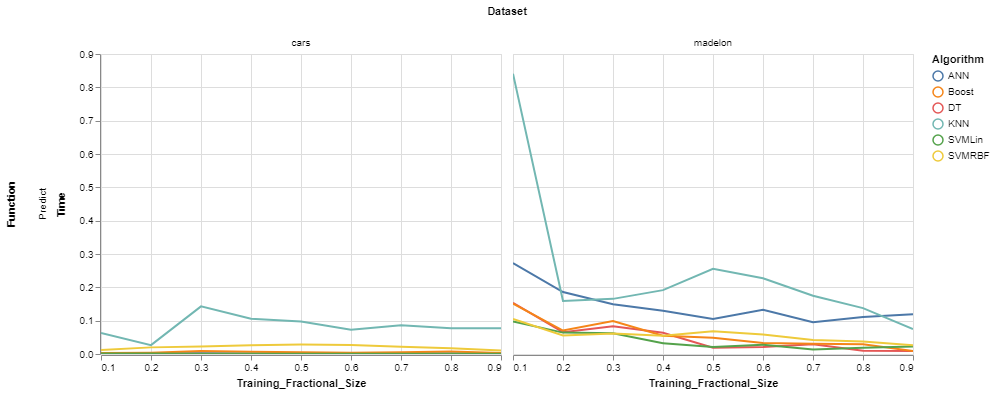

In [81]:
alt.Chart(timing_curves_all).mark_line().encode(
    alt.X('Training_Fractional_Size:Q'), 
    y=alt.Y('Time:Q'),
    color=alt.Color('Algorithm:N'),
    row='Function:N',
    column='Dataset:N',
).transform_filter(
    #(alt.datum.Algorithm != 'ANN') 
    #&
    (alt.datum.Function == 'Predict')
).interactive()

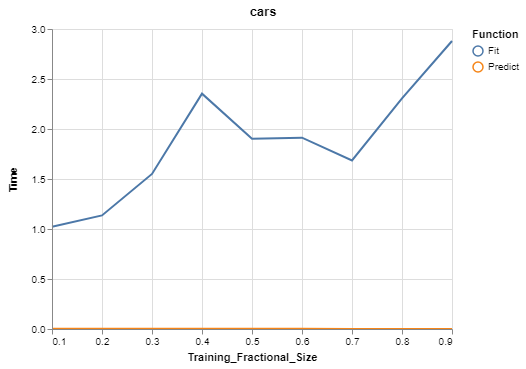

In [65]:
from itertools import accumulate
list(accumulate(cars_charts))[0]

## Overfitting Curves

Algorithm: ANN
Dataset: cars


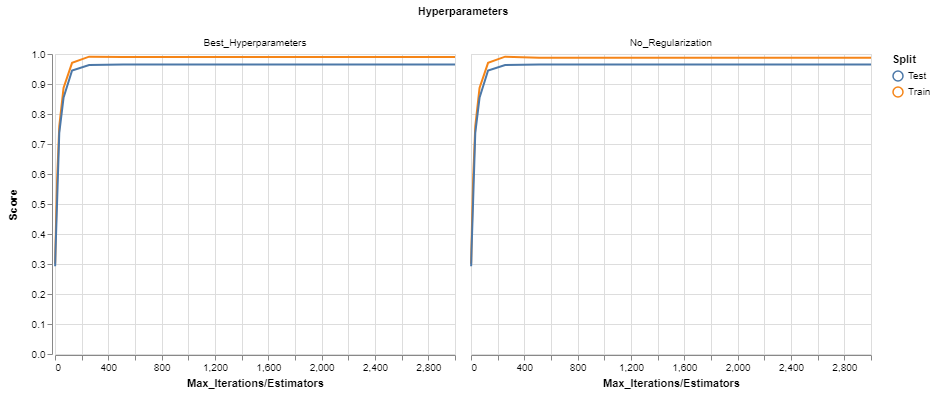

Algorithm: Boost
Dataset: cars


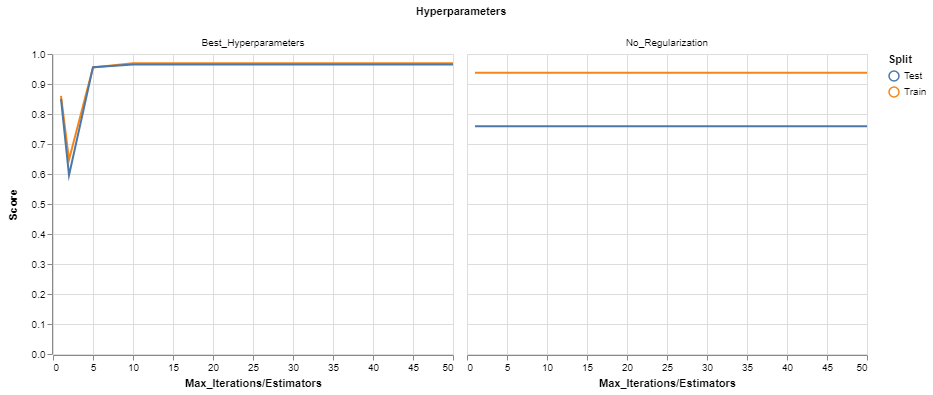

Algorithm: SVMLin
Dataset: cars


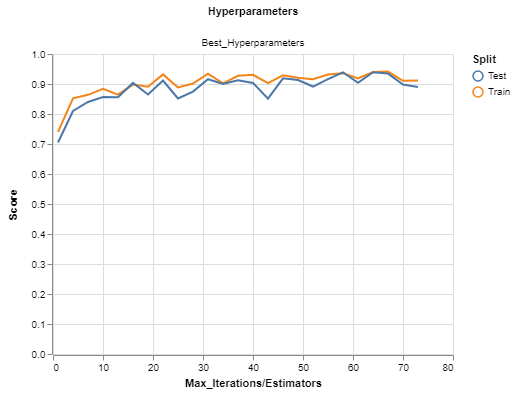

Algorithm: SVMRBF
Dataset: cars


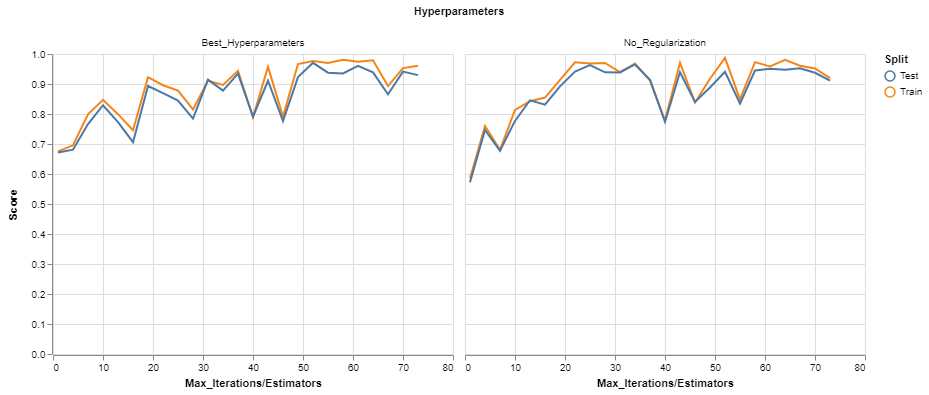

Algorithm: ANN
Dataset: madelon


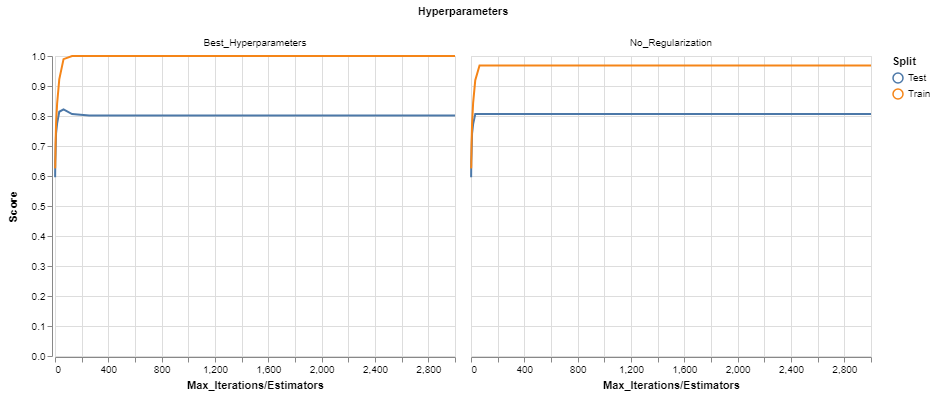

Algorithm: Boost
Dataset: madelon


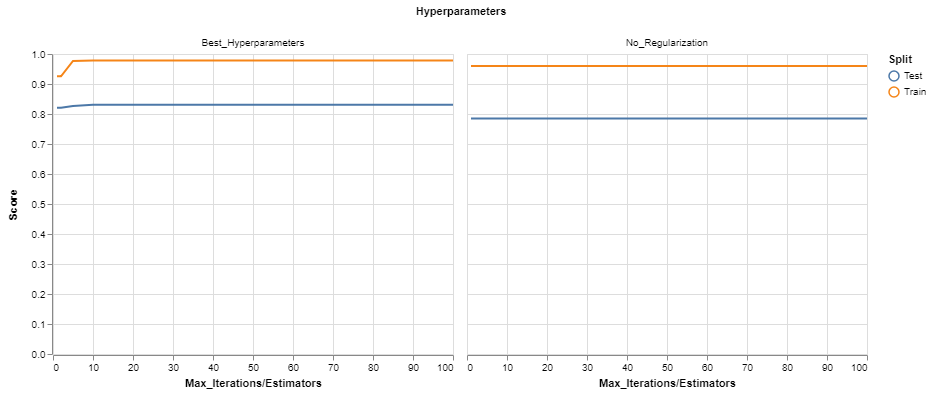

Algorithm: SVMLin
Dataset: madelon


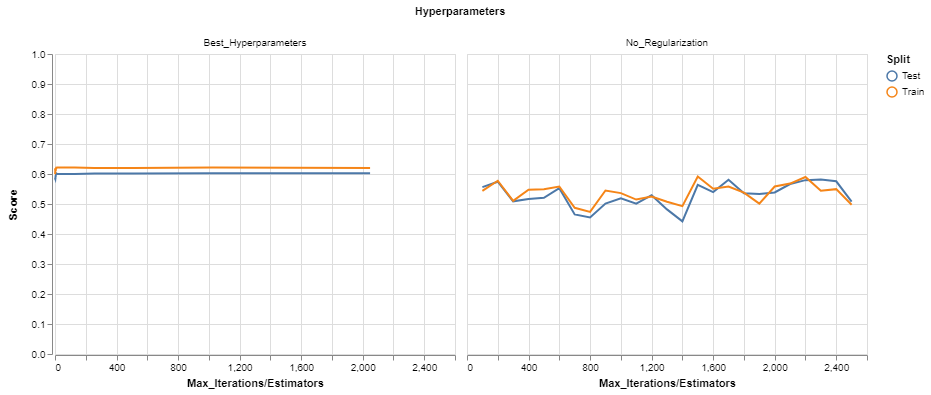

Algorithm: SVMRBF
Dataset: madelon


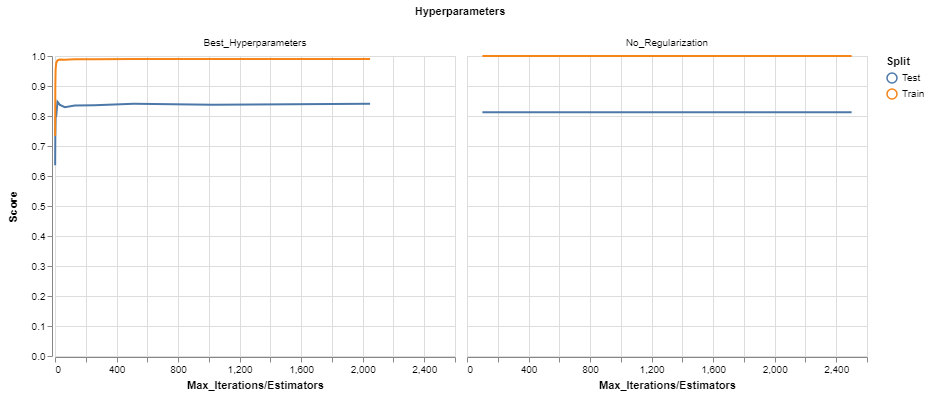

In [41]:
for dataset, algorithm in data_iterative_alg_combos:
    test_object = AlgorithmResults(results_fpath=RESULTS_PATH, 
                                   dataset=dataset,
                                   algorithm=algorithm,iterative=iterative_status_df[algorithm])
    
    print(f'Algorithm: {algorithm}')
    print(f'Dataset: {dataset}')    
    display(test_object.plot_overfitting_curve)

## Facet Plots

ANN


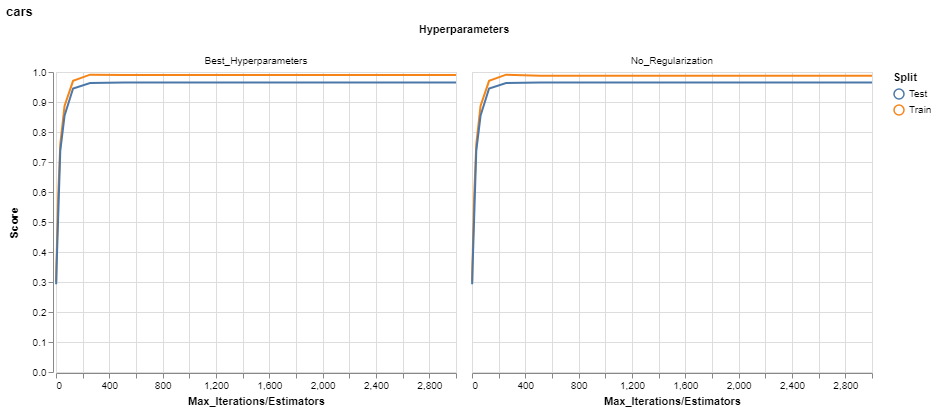

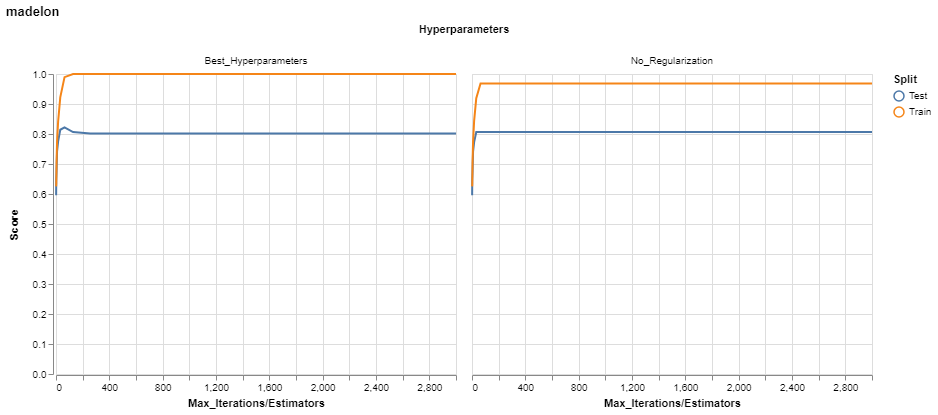

AttributeError: 'NoneType' object has no attribute 'properties'

In [42]:
for algorithm in learners:
    of_curves = []
    for dataset in sets:
        analysis_plotter = AlgorithmResults(results_fpath=RESULTS_PATH, 
                               dataset=dataset,
                               algorithm=algorithm,
                              iterative=iterative_status_df[algorithm])
        of_curves.append(analysis_plotter.plot_overfitting_curve.properties(
    title=f'{dataset}'))
    if of_curves:
        one, two = of_curves
        print(algorithm)
        display(one)
        display(two)

## Export all of these charts to folders

In [43]:
from selenium import webdriver

# Set Driver for Exporting
driver = webdriver.Chrome(r'C:\Users\afurrier\chromedriver.exe')

## Export Side by Side Learning Curves and Timing Curves

Learning Curves

In [44]:
for algorithm in learners:
    learning_curve_plots = []
    for dataset in sets:
        analysis_plotter = AlgorithmResults(results_fpath=RESULTS_PATH, 
                               dataset=dataset,
                               algorithm=algorithm,
                              iterative=iterative_status_df[algorithm])
        learning_curve_plots.append(analysis_plotter.plot_learning_curve.properties(
    title=f'{dataset}'))
    one, two = learning_curve_plots
    print(algorithm)
    combined_chart = (one | two)
    combined_chart.save(f'reports/figures/learning_curves/dataset_combined/{algorithm}.png', scale_factor=2.0)
    combined_chart.save(f'reports/figures/all/dataset_combined/{algorithm}_learning_curve.png', scale_factor=2.0)    

ANN
DT
Boost
KNN
SVMLin
SVMRBF


Timing Curves

In [45]:
for algorithm in learners:
    timing_curves = []
    for dataset in sets:
        analysis_plotter = AlgorithmResults(results_fpath=RESULTS_PATH, 
                               dataset=dataset,
                               algorithm=algorithm,
                              iterative=iterative_status_df[algorithm])
        timing_curves.append(analysis_plotter.plot_timing_curve.properties(
    title=f'{dataset}'))
    one, two = timing_curves
    print(algorithm)
    combined_chart = (one | two)
    combined_chart.save(f'reports/figures/timing_curves/dataset_combined/{algorithm}.png', scale_factor=2.0)
    combined_chart.save(f'reports/figures/all/dataset_combined/{algorithm}_timing_curves.png', scale_factor=2.0)    

ANN
DT
Boost
KNN
SVMLin
SVMRBF


In [46]:
for dataset, algorithm in data_alg_combos:
    test_object = AlgorithmResults(results_fpath=RESULTS_PATH, 
                                   dataset=dataset,
                                   algorithm=algorithm,
                                  iterative=iterative_status_df[algorithm])
    
    print(f'Algorithm: {algorithm}')
    print(f'Dataset: {dataset}')    
    
    learning_curve = test_object.plot_learning_curve
    learning_curve.save(f'reports/figures/learning_curves/{algorithm}_{dataset}.png', scale_factor=2.0)
    learning_curve.save(f'reports/figures/all/{algorithm}_{dataset}_learning_curve.png', scale_factor=2.0) 
    
    timing_curve = test_object.plot_timing_curve
    timing_curve.save(f'reports/figures/timing_curves//{algorithm}_{dataset}.png', scale_factor=2.0)
    timing_curve.save(f'reports/figures/all/{algorithm}_{dataset}_timing_curve.png', scale_factor=2.0)     
    of_curve = test_object.plot_overfitting_curve
    if of_curve:
        of_curve.save(f'reports/figures/of_curves//{algorithm}_{dataset}.png', scale_factor=2.0)
        of_curve.save(f'reports/figures/all/{algorithm}_{dataset}_OF_curve.png', scale_factor=2.0)     
    

Algorithm: ANN
Dataset: cars
Algorithm: Boost
Dataset: cars
Algorithm: DT
Dataset: cars
Algorithm: KNN
Dataset: cars
Algorithm: SVMLin
Dataset: cars
Algorithm: SVMRBF
Dataset: cars
Algorithm: ANN
Dataset: madelon
Algorithm: Boost
Dataset: madelon
Algorithm: DT
Dataset: madelon
Algorithm: KNN
Dataset: madelon
Algorithm: SVMLin
Dataset: madelon
Algorithm: SVMRBF
Dataset: madelon


In [47]:
of_dfs = []
for dataset, algorithm in data_iterative_alg_combos:
    test_object = AlgorithmResults(results_fpath=RESULTS_PATH, 
                                   dataset=dataset,
                                   algorithm=algorithm,iterative=iterative_status_df[algorithm])
    of_dfs.append(test_object.overfitting_curve_dfs)

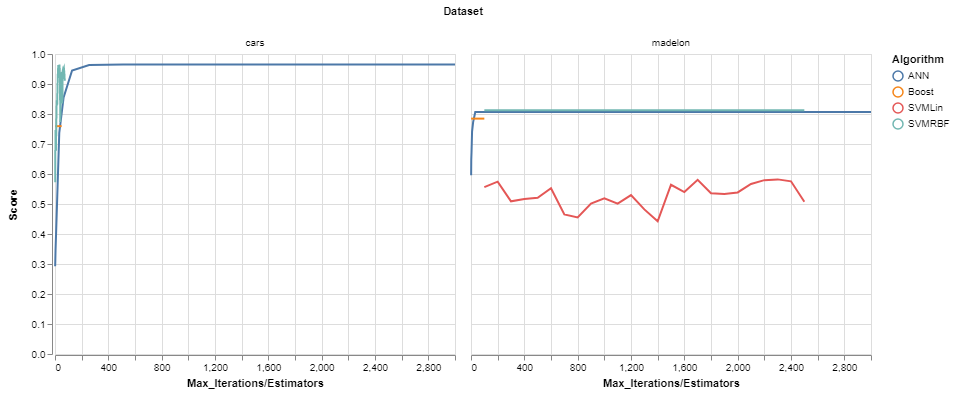

In [48]:
of_dfs_together = pd.concat(of_dfs)
of_dfs_together
alt.Chart(of_dfs_together).mark_line().encode(
    x=alt.X('Max_Iterations/Estimators:Q'),
    y=alt.Y('Score:Q'),
    column='Dataset',
    color='Algorithm',
).transform_filter(
    (alt.datum.Hyperparameters == 'No_Regularization') & (alt.datum.Split == 'Test')
)